In [32]:
from sys import exit
import numpy as np
import nifty7 as ift
import itertools
import random as rn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import fftpack
import numpy.ma as ma
import time
import numpy.linalg as la
from scipy.ndimage import gaussian_filter
from os.path import exists

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

# cosmic ray/domain parameters
c = 2.9979258 #* in units of 10^8 m/s
pc = 3.085677581 #* in units of 10^16 m
side_length = 3000 #pc
N_pixels = 50
cdt = side_length/N_pixels #* in units where cdt = 1pc
ell = cdt
energy = 0.5 #* in units of 10^20 eV
charge = 1 #* in units where q = Ze
# position = [-8300, 0, 0]#[x,y,z] in pc in Galactocentric cartesian system
position = [side_length/2, side_length/2, 0]
velocity = [0,0,-1] #[vx,vy,vz] such that norm is 1 (equal to c)
energy = 0.5
charge = 1

# N_data_points = 125
# frac = N_data_points/N_pixels**3
# anisotropy = True

def rms(arr):
    return np.sqrt(np.mean(arr**2))

def norm(arr):
    return np.sqrt(np.multiply(arr[0],arr[0])+np.multiply(arr[1],arr[1])+np.multiply(arr[2],arr[2]))

class Cosmic_ray:
    def __init__(self, position, velocity, energy, charge): #its morphin' time!
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        self.energy = energy
        self.charge = charge
        self.X_position = [self.position[0]]
        self.Y_position = [self.position[1]]
        self.Z_position = [self.position[2]]

    def update_velocity(self, new_velocity):
        self.velocity = np.array(new_velocity)

    def update_position(self, new_position):
        self.position = np.array(new_position)

    def backtracking_cubic_grid(self, mat):
        while abs(self.position[0]) < side_length and abs(self.position[1]) < side_length and abs(self.position[2]) < side_length:
            magnetic_field, magnetic_field_strength = Bfield(mat, self.position)
            D = (cdt * pc * c * self.charge * 1e-6) / self.energy
            A =  magnetic_field_strength * D
            previous_velocity = self.velocity - A * np.cross(self.velocity, magnetic_field)
            previous_position = self.position - self.velocity * cdt
            self.X_position.append(previous_position[0])
            self.Y_position.append(previous_position[1])
            self.Z_position.append(previous_position[2])

            self.update_position(previous_position)
            self.update_velocity(previous_velocity)
            self.velocity /= np.linalg.norm(self.velocity)

            
class div_cleaning(ift.LinearOperator):
    """
    Div cleaning operator operator
    ----------
    domain : real space domain on which the input field lives
    """
    def __init__(self, domain):
        self._domain = ift.makeDomain(domain)
        self._target = ift.makeDomain(domain)
        self._capability = self.TIMES | self.ADJOINT_TIMES

# call it in main body as O = Operator(correlated_field.target)
    def apply(self, x, mode):
        self._check_input(x, mode)
        if mode == self.TIMES:
            mat = x.val
            dft_mat = np.zeros([3, N_pixels, N_pixels, N_pixels], dtype=np.complex_)
            mat_div_cleaned = np.zeros([3, N_pixels, N_pixels, N_pixels])


            for index in range(0,3):
                dft_mat[index] = fftpack.fftn(mat[index])
                dft_mat[index] = fftpack.fftshift(dft_mat[index])

            k = np.mgrid[:N_pixels,:N_pixels,:N_pixels] - N_pixels/2
            k_norm_sq = np.multiply(k[0],k[0]) + np.multiply(k[1],k[1]) + np.multiply(k[2],k[2])
            inner_product = np.multiply(dft_mat[0],k[0]) + np.multiply(dft_mat[1],k[1]) + np.multiply(dft_mat[2],k[2])
            dft_mat_div_cleaned = np.where(k_norm_sq >= 1e-10, 3/2*(dft_mat - k*inner_product/k_norm_sq), dft_mat)

            for index in range(0,3):
                dft_mat_div_cleaned[index] = fftpack.ifftshift(dft_mat_div_cleaned[index])
                mat_div_cleaned[index] = np.real(fftpack.ifftn(dft_mat_div_cleaned[index]))

            return ift.sugar.makeField(self.target, mat_div_cleaned)
        if mode == self.ADJOINT_TIMES:
            mat = x.val
            dft_mat = np.zeros([3, N_pixels, N_pixels, N_pixels], dtype=np.complex_)
            mat_div_cleaned = np.zeros([3, N_pixels, N_pixels, N_pixels])


            for index in range(0,3):
                dft_mat[index] = fftpack.fftn(mat[index])
                dft_mat[index] = fftpack.fftshift(dft_mat[index])

            k = np.mgrid[:N_pixels,:N_pixels,:N_pixels] - N_pixels/2
            k_norm_sq = np.multiply(k[0],k[0]) + np.multiply(k[1],k[1]) + np.multiply(k[2],k[2])
            inner_product = np.multiply(dft_mat[0],k[0]) + np.multiply(dft_mat[1],k[1]) + np.multiply(dft_mat[2],k[2])
            dft_mat_div_cleaned = np.where(k_norm_sq >= 1e-10, 3/2*(dft_mat - k*inner_product/k_norm_sq), dft_mat)

            for index in range(0,3):
                dft_mat_div_cleaned[index] = fftpack.ifftshift(dft_mat_div_cleaned[index])
                mat_div_cleaned[index] = np.real(fftpack.ifftn(dft_mat_div_cleaned[index]))
            return ift.sugar.makeField(self.target, mat_div_cleaned)

def Bfield(mat, position): #measured in μG
    """
    Returns the unit vector and strength at position.
    """
    Bx = mat[0][int(position[0]/ell), int(position[1]/ell), int(position[2]/ell)]
    By = mat[1][int(position[0]/ell), int(position[1]/ell), int(position[2]/ell)]
    Bz = mat[2][int(position[0]/ell), int(position[1]/ell), int(position[2]/ell)]
    B = np.sqrt(Bx**2 + By**2 + Bz**2)
    unit_vector = np.array([Bx/B, By/B, Bz/B])
    strength = B
    return unit_vector, strength
        
def make_perc_mask(N, frac):
    # this function does the same as make_random_mask, but you get to chose the
    # percentage of pixels you want to keep.
    arr = np.asarray([0,1])
    mat = np.zeros(shape = (N,N,N))
    for i,j,k in itertools.product(range(N),range(N),range(N)):
        mat[i][j][k] = int(np.asarray(rn.choices(arr, weights=[frac, 1 - frac])))
    return mat

def main():
    N_data_points = 123
    frac = N_data_points/N_pixels**3
    anisotropy = False

    position_space = ift.RGSpace([N_pixels, N_pixels, N_pixels])

    #  For a detailed showcase of the effects the parameters
    #  of the CorrelatedField model have on the generated fields,
    #  see 'getting_started_4_CorrelatedFields.ipynb'.
    args = {
        # Amplitude of field fluctuations
        'fluctuations': (1e0, 1e0),

        # Exponent of power law power spectrum component. Choose a Kolmogorov slope
        # as a mean, and allow for a ± 1 std
        'loglogavgslope': (-11/3, 1e0),

        # Amplitude of integrated Wiener process power spectrum component
        'flexibility': (1.5e0,1e0),

        # How ragged the integrated Wiener process component is
        'asperity': None
    }

    cfmaker = ift.CorrelatedFieldMaker(prefix='', total_N=3)
    cfmaker.set_amplitude_total_offset(0., (1e-16, 1e-16))
    cfmaker.add_fluctuations(position_space, **args)
    pspec = cfmaker.power_spectrum
    signal = cfmaker.finalize()

    # Change model parameters for each component using dofdex

    #Define div cleaning operator.
    DC = div_cleaning(signal.target)

    # Define response operator
    mask = make_perc_mask(N_pixels, frac)
    mask = np.array([mask, mask, mask])
    mask = ift.Field.from_raw(signal.target, mask)
    # mask = ift.Field.from_raw(position_space, mask)
    R = ift.MaskOperator(mask)

    signal_response = R(DC(signal))

    mock_position = ift.from_random(signal_response.domain, 'normal')


    # This is in case you want to input the signal from_raw
    # mat = signal(mock_position).val
    # mock_signal = ift.Field.from_raw(signal.target, mat)

    #Create mock field and data
    # why not DCmock_signal = DC(signal(mock_position))
    DCmock_signal = DC(signal(mock_position))
    # DCmock_signal = DC(mock_signal)
    Barr = DCmock_signal.val #array of MF values on each voxel
    B_norm_arr = np.sqrt(np.multiply(Barr[0],Barr[0]) + np.multiply(Barr[1],Barr[1]) + np.multiply(Barr[2],Barr[2]))
    Brms = rms(B_norm_arr)
    if anisotropy == True:
        lam = 0.2 #turbulent-to-uniform ratio
        BrmsTrue = 1 #desired RMS value of random component (in μG)
        Barr = (BrmsTrue/Brms)*Barr #rescale random component so that it has RMS of BrmsTrue
        theta = 0. # rn.uniform(0,2*np.pi)
        phi = np.pi/2 #rn.uniform(0,np.pi)
        Barr[0] += 1/lam*np.cos(theta)*np.sin(phi) #magnitude of uniform component is set to 1/lam
        Barr[1] += 1/lam*np.sin(theta)*np.sin(phi)
        Barr[2] += 1/lam*np.cos(phi)
        B_norm_arr = np.sqrt(np.multiply(Barr[0],Barr[0]) + np.multiply(Barr[1],Barr[1]) + np.multiply(Barr[2],Barr[2]))
        BrmsTrue = 5 #desired RMS value of TOTAL field (in μG)
        Brms = rms(B_norm_arr)
        Barr = (BrmsTrue/Brms)*Barr #rescale true field so that it has RMS of (last) BrmsTrue
    elif anisotropy == False:
        BrmsTrue = 5 #desired RMS value of random component (in μG)
        Barr = (BrmsTrue/Brms)*Barr #rescale true field so that it has RMS of 5μG
    DCmock_signal = ift.Field.from_raw(signal.target, Barr) #the true field is now the rescaled one

    # Specify noise
    data_space = R.target
    # B_norm_arr = np.sqrt(np.multiply(Barr[0],Barr[0]) + np.multiply(Barr[1],Barr[1]) + np.multiply(Barr[2],Barr[2]))
    # Brms = rms(B_norm_arr)
    noiseCov = 5**2/4 #covariance of noise
    N = ift.ScalingOperator(data_space, noiseCov)

    data = R(DCmock_signal) + N.draw_sample_with_dtype(dtype=np.float64)

    if anisotropy == True:
            cfmaker = ift.CorrelatedFieldMaker(prefix='', total_N=3)
            cfmaker.add_fluctuations(position_space, **args)
    cfmaker.set_amplitude_total_offset(0, (3e0, 1e0))
    signal = cfmaker.finalize()

    # Notice that R(signal) & DC(signal) are of _OpChain type
    # While R(mock_signal) & DC(mock_signal) are of Field type
    print('Computation begins')
    ic_sampling = ift.AbsDeltaEnergyController(deltaE=0.05, iteration_limit=100)
    ic_newton = ift.AbsDeltaEnergyController(deltaE=0.5, convergence_level=2, iteration_limit=35)
    minimizer = ift.NewtonCG(ic_newton)
    ic_sampling_nl = ift.AbsDeltaEnergyController(deltaE=0.5, iteration_limit=15, convergence_level=2)
    minimizer_sampling = ift.NewtonCG(ic_sampling_nl)

    # Set up likelihood energy and information Hamiltonian
    likelihood_energy = (ift.GaussianEnergy(mean=data, inverse_covariance=N.inverse) @
                         R(DC(signal)))
    H = ift.StandardHamiltonian(likelihood_energy, ic_sampling)

    initial_mean = ift.MultiField.full(H.domain, 0.)
    mean = initial_mean

    # number of samples used to estimate the KL
    N_samples = 6

    # Draw new samples to approximate the KL six times
    for i in range(6):
        if i==5:
            # Double the number of samples in the last step for better statistics
            N_samples = 2*N_samples
        # Draw new samples and minimize KL
        KL = ift.GeoMetricKL(mean, H, N_samples, minimizer_sampling, True)
        KL, convergence = minimizer(KL)
        mean = KL.position
        ift.extra.minisanity(data, lambda x: N.inverse, signal_response,
                             KL.position, KL.samples)

    sc = ift.StatCalculator()
    posteriorSampleList = []
    for sample in KL.samples:
        sc.add(signal(sample + KL.position))
        posteriorSampleList.append(DC(signal(sample + KL.position)).val)
        
    data_arr = R.adjoint_times(data).val #Create ndarray with the mock observations


    if anisotropy == True:
        np.save("posterior_samples/Post_Samples_(N=%d_lambda=%.1f)"%(N_data_points, lam), posteriorSampleList)
        np.save("posterior_samples/Ground_truth_(N=%d_lambda=%.1f)"%(N_data_points, lam),DCmock_signal.val)
        np.save("posterior_samples/Posterior_mean_(N=%d_lambda=%.1f)"%(N_data_points, lam),DC(sc.mean).val)
        np.save("posterior_samples/Data_(N=%d_lambda=%.1f)"%(N_data_points, lam),data_arr)


    else:
        np.save("posterior_samples/Post_Samples_(N=%d_lambda=INF)"%N_data_points, posteriorSampleList)
        np.save("posterior_samples/Ground_truth_(N=%d_lambda=INF)"%N_data_points, DCmock_signal.val)
        np.save("posterior_samples/Posterior_mean_(N=%d_lambda=INF)"%N_data_points, DC(sc.mean).val)
        np.save("posterior_samples/Data_(N=%d_lambda=INF)"%N_data_points, data_arr)


if __name__ == '__main__':
    t = time.time()
    main()
    t = time.time() - t
    t *= 1/60 #time in minutes
    print('Total calculation time: %.2f minutes'%t)
    

Offset amplitude: 1.02E-16 ± 8.94E-17
Offset amplitude: 1.02E-16 ± 8.94E-17
Offset amplitude: 1.02E-16 ± 8.94E-17
Total fluctuation amplitude: 1.02E+00 ± 1.09E+00
Total fluctuation amplitude: 1.02E+00 ± 1.09E+00
Total fluctuation amplitude: 1.02E+00 ± 1.09E+00
/var/folders/xq/q124zgt57s1b50824byrsg_m0000gn/T/ipykernel_8976/2743845987.py:102: RuntimeWarning: invalid value encountered in true_divide
  dft_mat_div_cleaned = np.where(k_norm_sq >= 1e-10, 3/2*(dft_mat - k*inner_product/k_norm_sq), dft_mat)
Overwriting the previous mean offset and zero-mode
Offset amplitude: 3.01E+00 ± 9.95E-01
Offset amplitude: 3.01E+00 ± 9.95E-01
Offset amplitude: 3.01E+00 ± 9.95E-01
Total fluctuation amplitude: 1.16E+00 ± 2.01E+00
Total fluctuation amplitude: 1.16E+00 ± 2.01E+00
Total fluctuation amplitude: 1.16E+00 ± 2.01E+00
/var/folders/xq/q124zgt57s1b50824byrsg_m0000gn/T/ipykernel_8976/2743845987.py:122: RuntimeWarning: invalid value encountered in true_divide
  dft_mat_div_cleaned = np.where(k_norm_sq

Computation begins


Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
Iteration limit reached. Assuming convergence
                     reduced χ²          mean      # dof
--------------------------------------------------------
Data residuals
  <None>              1.8 ± 0.2    -0.1 ± 0.0        372
Latent space
  flexibility         0.8 ± 1.0    -0.6 ± 0.7          1
  fluctuations        0.9 ± 0.9     0.2 ± 1.0          1
  loglogavgslope      0.5 ± 0.4     0.5 ± 0.4          1
  spectrum            1.0 ± 0.0 

Total calculation time: 8.34 minutes


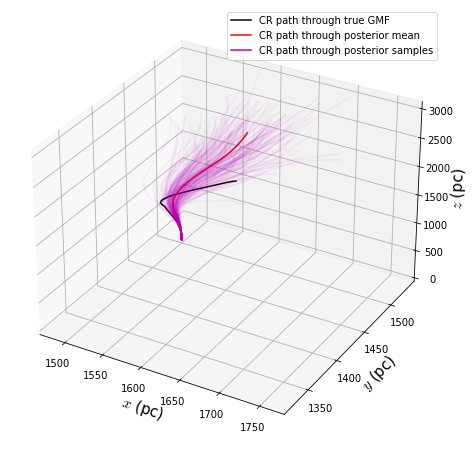

In [28]:
def backtrack_through_field(mat):
    cr_cubic_grid = Cosmic_ray(position, velocity, energy, charge)
    pos_bef_cubic_grid = galactic_coordinates_from_velocity(cr_cubic_grid.velocity)
    cr_cubic_grid.backtracking_cubic_grid(mat)
    pos_aft_cubic_grid = galactic_coordinates_from_velocity(cr_cubic_grid.velocity)

    return pos_aft_cubic_grid, cr_cubic_grid.X_position, cr_cubic_grid.Y_position, cr_cubic_grid.Z_position

def galactic_coordinates_from_velocity(velocity):
    v_x = velocity[0]
    v_y = velocity[1]
    v_z = velocity[2]

    b = np.arcsin(v_z)
    l = np.sign(v_y) * np.arccos(v_x / np.cos(b))
    if l < 0:
        l += 2 * np.pi
    return np.array([l, b])*180/np.pi

N_data_points = 1000
lam = 0.2
anisotropy = False

from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (12,8))
ax = plt.axes(projection='3d')

if anisotropy == True:
    posteriorSamplesList = np.load("posterior_samples/Post_Samples_(N=%d_lambda=%.1f).npy"%(N_data_points, lam))
    groundTruth = np.load("posterior_samples/Ground_truth_(N=%d_lambda=%.1f).npy"%(N_data_points, lam))
    posteriorMean = np.load("posterior_samples/Posterior_mean_(N=%d_lambda=%.1f).npy"%(N_data_points, lam))
else:
    posteriorSamplesList = np.load("posterior_samples/Post_Samples_(N=%d_lambda=INF).npy"%N_data_points)
    groundTruth = np.load("posterior_samples/Ground_truth_(N=%d_lambda=INF).npy"%N_data_points)
    posteriorMean = np.load("posterior_samples/Posterior_mean_(N=%d_lambda=INF).npy"%N_data_points)
    

velocity_PoS = galactic_coordinates_from_velocity(velocity)
v_true, Xpos, Ypos, Zpos = backtrack_through_field(groundTruth)
ax.plot(Xpos, Ypos, Zpos, color = 'k', label = 'CR path through true GMF')

v_mean, Xpos, Ypos, Zpos = backtrack_through_field(posteriorMean)
ax.plot(Xpos,Ypos,Zpos, color = 'r', label = 'CR path through posterior mean')
# Xpos = np.ones(len(Xpos))*1500
# Ypos = np.ones(len(Ypos))*1500
# Zpos = np.linspace(0,3000,len(Ypos))
# ax.plot(Xpos, Ypos, Zpos, color = 'k', label = 'CR path neglecting the GMF')

v_samples = []
for field in posteriorSamplesList:
    rec_position, Xpos, Ypos, Zpos = backtrack_through_field(field)
    v_samples.append(rec_position)
    ax.plot(Xpos,Ypos,Zpos, color = 'm', alpha = 0.05)

ax.plot(Xpos,Ypos,Zpos, color = 'm', alpha = 0.1, label = 'CR path through posterior samples')
v_samples = np.array(v_samples)

ax.set_xlabel(r'$x$ (pc)', fontsize=15)
ax.set_ylabel(r'$y$ (pc)', fontsize=15)
ax.set_zlabel(r'$z$ (pc)', fontsize=15)
leg = ax.legend(loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
# ax.axes.set_xlim3d(left=0, right=3000)
# ax.axes.set_ylim3d(bottom=0, top=3000)
# ax.axes.set_zlim3d(bottom=0, top=3000)
plot = False
plt.show()
   

In [29]:
import scipy.stats as st
x = v_samples[:,0]
y = v_samples[:,1]
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)

In [30]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)



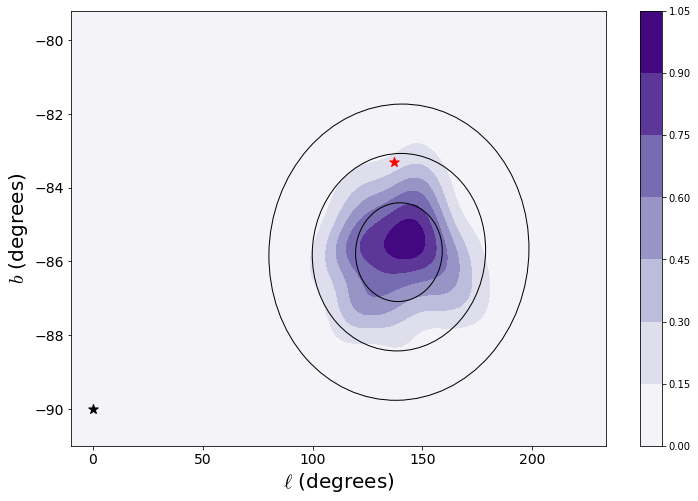

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

cmap = 'Purples'

xmin, xmax = -10, np.max(x) 
ymin, ymax = -91, np.max(y)+ 2


# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
f *= 1/np.max(f)

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap=cmap, vmax = 1)
plt.colorbar(cfset)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
# cset = ax.contour(xx, yy, f, colors='k')
plt.scatter(v_true[0], v_true[1], marker = '*', color = 'red', s = 1e2)
plt.scatter(velocity_PoS[0], velocity_PoS[1], marker = '*', color = 'black', s = 1e2)
# Label plot
ax.set_xlabel(r'$\ell$ (degrees)', fontsize = 20)
ax.set_ylabel(r'$b$ (degrees)', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=8)

# axins = zoomed_inset_axes(ax,2.7,loc='center')
# axins.contourf(xx, yy, f, cmap=cmap)
# cset = axins.contour(xx, yy, f, colors='k', alpha = 0.)
# ax.clabel(cset, inline=1, fontsize=20)

# x1,x2,y1,y2 = np.min(x), np.max(x), np.min(y), np.max(y)
# axins.set_xlim(x1,x2)
# axins.set_ylim(y1,y2)

stds = [1., 2., 3.]
edgecolor = 'black'
for sigma in stds:
    confidence_ellipse(x, y, ax, edgecolor = edgecolor, n_std = sigma)
#     confidence_ellipse(x, y, axins, edgecolor = edgecolor, n_std = sigma)

# mark_inset(ax,axins,loc1=2,loc2=4)
axins.scatter(v_true[0], v_true[1], marker = '*', color = 'red', s = 1e2)

plt.show()

In [15]:
# Computation of Mahalanobis distance
from numpy.linalg import inv
from scipy.spatial import distance

VI = inv(np.cov(x,y))
print(distance.mahalanobis(v_true, v_mean, VI))
print(distance.mahalanobis(velocity_PoS, v_mean, VI))

2.0266994684139283
7.606341995807196


In [25]:
# Plotting results
################################################################################
cr_cubic_grid = Cosmic_ray(position, velocity, energy, charge)
cr_cubic_grid.backtracking_cubic_grid(groundTruth)
v_true_vec = cr_cubic_grid.velocity

cr_cubic_grid = Cosmic_ray(position, velocity, energy, charge)
cr_cubic_grid.backtracking_cubic_grid(posteriorMean)
v_mean_vec = cr_cubic_grid.velocity

theta_arrays = np.array([])
for field in posteriorSamplesList:
    theta_arrays = np.append(theta_arrays, deflection(field,v_true))

deltaTheta1 = np.mean(theta_arrays) #angle between the initial velocities obtained by backtracking through a) reconstructed and b) actual field

deltaTheta2 = np.arccos(np.dot(v_true_vec,velocity))*180/np.pi 

deltaTheta3 = np.arccos(np.dot(v_true_vec,v_mean_vec))*180/np.pi 

print(deltaTheta1)
print(deltaTheta2)
print(deltaTheta3)

ValueError: shapes (3,) and (2,) not aligned: 3 (dim 0) != 2 (dim 0)

In [15]:
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='moll',lon_0=-180, resolution='c')

KeyError: 'PROJ_LIB'

In [25]:
import numpy as np

arr1 = [[1,0],[0,1]]
arr = np.array([arr1,arr1,arr1])
arr[2] = np.zeros((2,2))
print(arr[2])

[[0 0]
 [0 0]]


In [4]:
import numpy as np
Narray = np.linspace(1,5000,100)

In [5]:
print(Narray)

[1.00000000e+00 5.14949495e+01 1.01989899e+02 1.52484848e+02
 2.02979798e+02 2.53474747e+02 3.03969697e+02 3.54464646e+02
 4.04959596e+02 4.55454545e+02 5.05949495e+02 5.56444444e+02
 6.06939394e+02 6.57434343e+02 7.07929293e+02 7.58424242e+02
 8.08919192e+02 8.59414141e+02 9.09909091e+02 9.60404040e+02
 1.01089899e+03 1.06139394e+03 1.11188889e+03 1.16238384e+03
 1.21287879e+03 1.26337374e+03 1.31386869e+03 1.36436364e+03
 1.41485859e+03 1.46535354e+03 1.51584848e+03 1.56634343e+03
 1.61683838e+03 1.66733333e+03 1.71782828e+03 1.76832323e+03
 1.81881818e+03 1.86931313e+03 1.91980808e+03 1.97030303e+03
 2.02079798e+03 2.07129293e+03 2.12178788e+03 2.17228283e+03
 2.22277778e+03 2.27327273e+03 2.32376768e+03 2.37426263e+03
 2.42475758e+03 2.47525253e+03 2.52574747e+03 2.57624242e+03
 2.62673737e+03 2.67723232e+03 2.72772727e+03 2.77822222e+03
 2.82871717e+03 2.87921212e+03 2.92970707e+03 2.98020202e+03
 3.03069697e+03 3.08119192e+03 3.13168687e+03 3.18218182e+03
 3.23267677e+03 3.283171